# Journal 2022-09-05
Get Flax MNIST classifier working on [Coral.ai Edge TPU USB accelerator](https://coral.ai/products/accelerator) following on from the [previous journal entry](journal_20220902.ipynb)

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from flax import serialization
import os
import jax
import jax.numpy as jnp
import tensorflow as tf
import functools
import subprocess
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

In [3]:
from journal_20220902 import get_datasets, CNN, run_training, CnnParams

In [4]:
ds_train, ds_test = get_datasets()

In [5]:
model_file_root = 'mnist_flax_20220902'
cnn_params = CnnParams.from_file(model_file_root + '.bin')

In [6]:
cnn_params.predict(ds_test['image'][:10])

DeviceArray([2, 0, 4, 8, 7, 6, 0, 6, 3, 1], dtype=int32)

In [7]:
ds_test['label'][:10, ...]

array([2, 0, 4, 8, 7, 6, 0, 6, 3, 1])

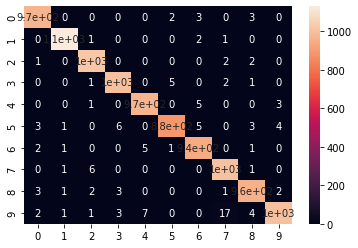

In [8]:
cm = confusion_matrix(cnn_params.predict(ds_test['image']), ds_test['label'])
_ = sns.heatmap(cm, annot=True)

# Convert to TFLite

In [9]:
tflite_file = model_file_root + '.tflite'
converter = cnn_params.to_tflite(tflite_file)

Try running the TFLite model

In [10]:
interpreter = tf.lite.Interpreter(tflite_file)
interpreter.allocate_tensors()
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

In [11]:
def tflite_predict(ind):
    interpreter.set_tensor(
        input_details[0]["index"], 
        ds_test['image'][jnp.newaxis,ind, ...].astype(jnp.float32)
    )
    interpreter.invoke()
    result = interpreter.get_tensor(output_details[0]["index"])
    return result[0]

In [12]:
tflite_predict(0)

2

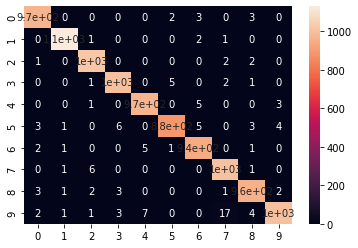

In [13]:
preds = jnp.array([tflite_predict(i) for i in range(len(ds_test['image']))])
cm = confusion_matrix(preds, ds_test['label'])
_ = sns.heatmap(cm, annot=True)

# Compile TFLite model to use EdgeTPU

In [14]:
result = subprocess.run(['edgetpu_compiler', tflite_file], stdout=subprocess.PIPE)
print(result.stdout.decode())

Edge TPU Compiler version 16.0.384591198
Started a compilation timeout timer of 180 seconds.

Model compiled successfully in 22 ms.

Input model: mnist_flax_20220902.tflite
Input size: 3.30MiB
Output model: mnist_flax_20220902_edgetpu.tflite
Output size: 3.29MiB
On-chip memory used for caching model parameters: 0.00B
On-chip memory remaining for caching model parameters: 0.00B
Off-chip memory used for streaming uncached model parameters: 0.00B
Number of Edge TPU subgraphs: 0
Total number of operations: 12
Operation log: mnist_flax_20220902_edgetpu.log

Model successfully compiled but not all operations are supported by the Edge TPU. A percentage of the model will instead run on the CPU, which is slower. If possible, consider updating your model to use only operations supported by the Edge TPU. For details, visit g.co/coral/model-reqs.
Number of operations that will run on Edge TPU: 0
Number of operations that will run on CPU: 12
See the operation log file for individual operation detai

Well it compiles at least, but no ops are going to be run on the TPU :(  

In [15]:
with open(model_file_root + '_edgetpu.log', 'r') as f:
    log = f.read()
print(log)

Edge TPU Compiler version 16.0.384591198
Input: mnist_flax_20220902.tflite
Output: mnist_flax_20220902_edgetpu.tflite

Operator                       Count      Status

ADD                            4          Operation is working on an unsupported data type
RESHAPE                        1          Operation is working on an unsupported data type
ARG_MAX                        1          Operation is working on an unsupported data type
DEPTHWISE_CONV_2D              1          Operation is working on an unsupported data type
FULLY_CONNECTED                2          Operation is working on an unsupported data type
AVERAGE_POOL_2D                2          Operation is working on an unsupported data type
CONV_2D                        1          Operation is working on an unsupported data type



The problem is the model uses the [wrong data type](https://coral.ai/docs/edgetpu/faq/#how-do-i-create-a-tensorflow-lite-model-for-the-edge-tpu), it needs to be quantized to use uint8.

Two options: retrain with quantization aware training, or quantize the existing trained model.  The latter will give worse performance but is the thing to try first.

Follow the [Retrain a MobileNet V2 model](https://colab.research.google.com/github/google-coral/tutorials/blob/master/retrain_classification_ptq_tf2.ipynb) example from the Coral.Ai doc

In [16]:
def representative_data_generator():
    for i in range(100):
        image = ds_train['image'][i][jnp.newaxis, ...].astype(jnp.float32)
        yield [image]

In [17]:
# This enables quantization
converter.optimizations = [tf.lite.Optimize.DEFAULT]
# This sets the representative dataset for quantization
converter.representative_dataset = representative_data_generator
# This ensures that if any ops can't be quantized, the converter throws an error
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
# For full integer quantization, though supported types defaults to int8 only, we explicitly declare it for clarity.
converter.target_spec.supported_types = [tf.int8]
# These set the input and output tensors to uint8 (added in r2.3)
converter.inference_input_type = tf.uint8
converter.inference_output_type = tf.uint8
tflite_quant_model = converter.convert()
tflite_quant_file = model_file_root + '_quant.tflite'
with open(tflite_quant_file, 'wb') as f:
    f.write(tflite_quant_model)

In [18]:
interpreter = tf.lite.Interpreter(tflite_quant_file)
interpreter.allocate_tensors()
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

In [19]:
scale, zero_point = input_details[0]['quantization']
scale, zero_point

(0.003921568859368563, 0)

In [20]:
def tflite_quant_predict(ind):
    interpreter.set_tensor(
        input_details[0]["index"], 
        jnp.uint8(ds_test['image'][jnp.newaxis,ind, ...] / scale + zero_point)
    )
    interpreter.invoke()
    result = interpreter.get_tensor(output_details[0]["index"])
    return result[0]

In [21]:
tflite_quant_predict(0)

2

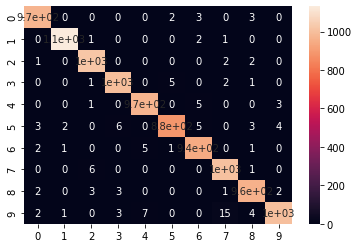

In [22]:
preds = jnp.array([tflite_quant_predict(i) for i in range(len(ds_test['image']))])
cm = confusion_matrix(preds, ds_test['label'])
_ = sns.heatmap(cm, annot=True)

# Compile Quantized TFLite Model to use EdgeTPU

In [23]:
result = subprocess.run(['edgetpu_compiler', tflite_quant_file], stdout=subprocess.PIPE)
print(result.stdout.decode())

Edge TPU Compiler version 16.0.384591198
Started a compilation timeout timer of 180 seconds.

Model compiled successfully in 697 ms.

Input model: mnist_flax_20220902_quant.tflite
Input size: 852.10KiB
Output model: mnist_flax_20220902_quant_edgetpu.tflite
Output size: 877.12KiB
On-chip memory used for caching model parameters: 822.00KiB
On-chip memory remaining for caching model parameters: 7.04MiB
Off-chip memory used for streaming uncached model parameters: 1.50KiB
Number of Edge TPU subgraphs: 1
Total number of operations: 13
Operation log: mnist_flax_20220902_quant_edgetpu.log

Model successfully compiled but not all operations are supported by the Edge TPU. A percentage of the model will instead run on the CPU, which is slower. If possible, consider updating your model to use only operations supported by the Edge TPU. For details, visit g.co/coral/model-reqs.
Number of operations that will run on Edge TPU: 12
Number of operations that will run on CPU: 1
See the operation log file

Looking much better!  Have a look at the log to see what isn't running on the TPU

In [24]:
with open(model_file_root + '_quant_edgetpu.log', 'r') as f:
    log = f.read()
print(log)

Edge TPU Compiler version 16.0.384591198
Input: mnist_flax_20220902_quant.tflite
Output: mnist_flax_20220902_quant_edgetpu.tflite

Operator                       Count      Status

CONV_2D                        1          Mapped to Edge TPU
FULLY_CONNECTED                2          Mapped to Edge TPU
QUANTIZE                       1          Mapped to Edge TPU
ARG_MAX                        1          Operation is working on an unsupported data type
ADD                            4          Mapped to Edge TPU
RESHAPE                        1          Mapped to Edge TPU
AVERAGE_POOL_2D                2          Mapped to Edge TPU
DEPTHWISE_CONV_2D              1          Mapped to Edge TPU



Interesting, the final `argmax` to return index into list of labels isn't being mapped to the EdgeTPU.  This will significantly slow things down so probably worth removing (or compare before and after).

# Compare Timings 
Try running on CPU, running on EdgeTPU

In [25]:
%timeit [tflite_quant_predict(i) for i in range(100)]

169 ms ± 17.9 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [26]:
import tflite_runtime.interpreter as tflite

In [27]:
tflite_quant_edge_file = model_file_root + '_quant_edgetpu.tflite'
interpreter = tflite.Interpreter(tflite_quant_edge_file,
  experimental_delegates=[tflite.load_delegate('libedgetpu.so.1')])

In [28]:
interpreter.allocate_tensors()
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

In [29]:
scale, zero_point = input_details[0]['quantization']
scale, zero_point

(0.003921568859368563, 0)

In [30]:
def tflite_quant_edge_predict(ind):
    interpreter.set_tensor(
        input_details[0]["index"], 
        jnp.uint8(ds_test['image'][jnp.newaxis,ind, ...] / scale + zero_point)
    )
    interpreter.invoke()
    result = interpreter.get_tensor(output_details[0]["index"])
    return result[0]

In [31]:
tflite_quant_predict(0)

2

In [32]:
%timeit [tflite_quant_edge_predict(i) for i in range(100)]

73.4 ms ± 3.47 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


Ok, so 2x speedup but remember not everything is running on the TPU due to the argmax op

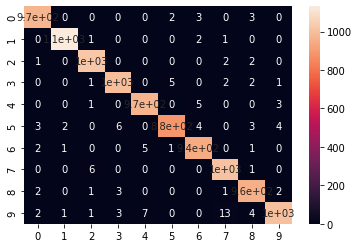

In [33]:
preds = jnp.array([tflite_quant_edge_predict(i) for i in range(len(ds_test['image']))])
cm = confusion_matrix(preds, ds_test['label'])
_ = sns.heatmap(cm, annot=True)

# Create an optimized version of the serving function
Remove the final `argmax` operation so that everything goes to the TPU

In [34]:
cnn = CNN()
serving_fn = lambda x: cnn.apply({'params': cnn_params.params}, x)
x_input = jnp.zeros((1, 28, 28, 1))  # BHWC
converter = tf.lite.TFLiteConverter.experimental_from_jax(
    [serving_fn], [[('input1', x_input)]]
)

# This enables quantization
converter.optimizations = [tf.lite.Optimize.DEFAULT]
# This sets the representative dataset for quantization
converter.representative_dataset = representative_data_generator
# This ensures that if any ops can't be quantized, the converter throws an error
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
# For full integer quantization, though supported types defaults to int8 only, we explicitly declare it for clarity.
converter.target_spec.supported_types = [tf.int8]
# These set the input and output tensors to uint8 (added in r2.3)
converter.inference_input_type = tf.uint8
converter.inference_output_type = tf.uint8
tflite_quant_opt_model = converter.convert()
tflite_quant_opt_file = model_file_root + '_quant_opt.tflite'
with open(tflite_quant_opt_file, 'wb') as f:
    f.write(tflite_quant_opt_model)

In [35]:
result = subprocess.run(['edgetpu_compiler', tflite_quant_opt_file], stdout=subprocess.PIPE)
print(result.stdout.decode())

Edge TPU Compiler version 16.0.384591198
Started a compilation timeout timer of 180 seconds.

Model compiled successfully in 505 ms.

Input model: mnist_flax_20220902_quant_opt.tflite
Input size: 851.80KiB
Output model: mnist_flax_20220902_quant_opt_edgetpu.tflite
Output size: 876.62KiB
On-chip memory used for caching model parameters: 822.00KiB
On-chip memory remaining for caching model parameters: 7.04MiB
Off-chip memory used for streaming uncached model parameters: 1.50KiB
Number of Edge TPU subgraphs: 1
Total number of operations: 13
Operation log: mnist_flax_20220902_quant_opt_edgetpu.log
See the operation log file for individual operation details.
Compilation child process completed within timeout period.
Compilation succeeded! 



In [36]:
with open(model_file_root + '_quant_opt_edgetpu.log', 'r') as f:
    log = f.read()
print(log)

Edge TPU Compiler version 16.0.384591198
Input: mnist_flax_20220902_quant_opt.tflite
Output: mnist_flax_20220902_quant_opt_edgetpu.tflite

Operator                       Count      Status

DEPTHWISE_CONV_2D              1          Mapped to Edge TPU
AVERAGE_POOL_2D                2          Mapped to Edge TPU
QUANTIZE                       2          Mapped to Edge TPU
CONV_2D                        1          Mapped to Edge TPU
FULLY_CONNECTED                2          Mapped to Edge TPU
ADD                            4          Mapped to Edge TPU
RESHAPE                        1          Mapped to Edge TPU



In [37]:
tflite_quant_opt_edge_file = model_file_root + '_quant_opt_edgetpu.tflite'
interpreter = tflite.Interpreter(tflite_quant_opt_edge_file,
  experimental_delegates=[tflite.load_delegate('libedgetpu.so.1')])

In [38]:
interpreter.allocate_tensors()
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

In [39]:
scale, zero_point = input_details[0]['quantization']
scale, zero_point

(0.003921568859368563, 0)

In [40]:
def tflite_quant_opt_edge_predict(ind):
    interpreter.set_tensor(
        input_details[0]["index"], 
        jnp.uint8(ds_test['image'][jnp.newaxis,ind, ...] / scale + zero_point)
    )
    interpreter.invoke()
    result = interpreter.get_tensor(output_details[0]["index"])
    return result[0]

In [41]:
tflite_quant_opt_edge_predict(0)

array([ 39, 106, 205, 109,  81,  41,  56,  94, 110,  76], dtype=uint8)

In [42]:
%timeit [tflite_quant_opt_edge_predict(i) for i in range(100)]

76.8 ms ± 4.83 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [43]:
%timeit [jnp.argmax(tflite_quant_opt_edge_predict(i)) for i in range(100)]

77.7 ms ± 5.17 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [44]:
jnp.argmax(tflite_quant_opt_edge_predict(0))

DeviceArray(2, dtype=int32)

So it doesn't look like moving absolutely all the opertions to the EdgeTPU helped that much, although we're only doing one inference at a time.  Maybe changing the input size to be a bigger batch would help.

The [Netron](https://github.com/lutzroeder/netron) graph of the optimized model is quite nice though :) 

![optized EdgeTPU model](mnist_flax_20220902_quant_opt_edgetpu.tflite.png)

Compare with the original TFLite model:

![original model](mnist_flax_20220902.tflite.png)